In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.cross_validation import train_test_split
from sklearn.utils import shuffle

import time, json

# local imports
from activation_function import Sigmoid
from cost_function import CrossEntropy

In [ ]:
%matplotlib inline

## MNIST Stuff

In [ ]:
def load_mnist_dataset():
    '''
    Loads the mnist dataset from a folder
    :return: The training and tessting sets as specified by the mnist package
    '''
    mndata = pd.read_csv('../../datasets/MNIST/train.csv')
    labels_train = mndata['label']
    X_train = mndata.drop('label', axis=1).as_matrix()
    return X_train, labels_train
def mnist_classify(yhat):
    '''
    Takes in one-hot encoded vectors of the mnist dataset
    and returns the most probable digit.
    Simply returns the index of the maximum value
    :param yhat: 10xnum_samples
    :return: digit of highest classification probability
    '''
    return np.argmax(yhat, axis=1)
def accuracy(y, yhat):
    '''
    Calculates the accuracy of a network prediction yhat for label values y
    :param y:
    :param yhat:
    :return:
    '''
    return np.sum(mnist_classify(y) == mnist_classify(yhat)) / len(y)

In [ ]:
def one_hot(labels_train, num_classes=10):
    '''Convert categorical labels to standard basis vectors in R^{num_classes} '''
    return np.eye(num_classes)[labels_train]

In [81]:
plot_every = 10
class NeuralNet:
    '''
    A Neural Network class.
    Uses the logistic as all activation functions.
    The bias terms are separate from the weight matrix.
    '''
    def __init__(self, sizes):
        '''
        Creates a neural net where the hidden layers are all activated by ReLUs and the output is activated by softmax
        :param: neurons - the number of neurons per layer
        e.g. [2,3,4] would indicate a network that has 3 layers with
        2 neurons in the input, 4 on the output, and 3 in the single hidden layer
        '''
        assert len(sizes) >= 2, "Sizes must include input and output sizes;len > =2"
        self.n_input = sizes[0]  # number of input neurons
        self.n_output = sizes[-1]  # number of output neurons
        self.n_layers = len(sizes) - 1
        self.sizes = sizes
        self.create_net()

    def create_net(self):
        '''
        Initializes the weights and acitvation functions of the net
        '''
        self.weights = []
        self.biases = []
        for i, o in zip(self.sizes[:-1], self.sizes[1:]):
            self.weights.append(np.random.randn(o, i ) / np.sqrt(o))
            self.biases.append(np.random.randn(o, 1))
        self.fn = (self.n_layers) * [Sigmoid]

    def feed(self, x):
        '''
        Internal feed forward for SGD. 
        '''
        x = x.T
        self.activations = [x]
        self.sums = [x]
        for w, b, a in zip(self.weights, self.biases, self.fn):
            linear_combo = w @ x + b
            x = a.fn(linear_combo)
            self.sums.append(linear_combo)
            self.activations.append(x)
        return x if 1 in x.shape else x.T

    def _update_weights(self, learning_rate):
        ''' Takes the stored deltaweights and updates all the weights.
        Useful so backpropagation doesn't require any extra copying.'''
        for i in range(len(self.weights)):
            self.weights[i] = self.weights[i] - learning_rate * self.dweights[i]
            self.biases[i] = self.biases[i] - learning_rate * self.dbiases[i]

    def train(self, X_train, y_train, iterations, X_validation=[], y_validation=[], learning_rate=1e-3):
        '''
        SGD training w/ mini-batch size 1
        '''
        training_loss, validation_loss = [], []
        training_accuracy, validation_accuracy = [], []

        for e in range(iterations):
            X_train, y_train = shuffle(X_train, y_train)
            # the stochastic part
            # reshape to place the data on the rows
            x = X_train[0].reshape((1,self.n_input))
            y = y_train[0].reshape((self.n_output, 1))
            yhat = self.feed(x)

            delta = yhat - y

            # reinitialize dweights
            self.dweights = [np.zeros(w.shape) for w in self.weights]
            self.dbiases = [np.zeros(b.shape) for b in self.biases]
            self.dweights[-1] = np.outer(delta, self.activations[-2])
            self.dweights[-1] = delta

            prevWeights = self.weights[-1]
            for l in range(2, len(self.weights) + 1):
                dact = self.fn[-l].deriv
                sum_inputs = self.sums[-l]
                # remove the last row because it is the result on the bias
                # we don't deal with that in our delta calculation
                delta = dact(sum_inputs) * (prevWeights.T @ delta)
                self.dbiases[-l] = delta
                self.dweights[-l] = np.outer(delta, self.activations[-(l + 1)])
                prevWeights = self.weights[-l]
            self._update_weights(learning_rate)
            if e % plot_every == 0:
                train_feed = self.feed(X_train)
                training_loss.append(CrossEntropy.fn(y_train, train_feed))
                training_accuracy.append(accuracy(y_train, train_feed))
                if len(X_validation) > 0:
                    validation_feed = self.feed(X_validation)
                    validation_loss.append(CrossEntropy.fn(y_validation, validation_feed))
                    validation_accuracy.append(accuracy(y_validation, validation_feed))
        return training_loss, validation_loss, training_accuracy, validation_accuracy

    def save(self, filename='net'):
        '''
        Save the neural network
        '''
        data = {"sizes": self.sizes,
                "weights": [w.tolist() for w in self.weights],
                "biases" : [b.tolist() for b in self.biases]
                }
        f = open(filename, "w")
        json.dump(data, f)
        f.close()
        
def load(filename):
    '''
    Load a neural network from the file ``filename``.  Returns an
    instance of Network.
    '''
    f = open(filename, "r")
    data = json.load(f)
    f.close()
    net = NeuralNet(data["sizes"])
    net.weights = [np.array(w) for w in data["weights"]]
    net.biases = [np.array(b) for b in data["biases"]]
    return net

In [82]:
def plot_error(training_error, validation_error, title, save=False):
    plt.figure()
    plt.title(title)
    plt.plot(training_error, label="training")
    plt.xlabel('Iteration ${0}$x'.format(plot_every))
    plt.plot(validation_error, label="validation")
    plt.legend()
    if save:
        plt.savefig(title)

In [74]:
print("Loading MNIST dataset")
features_train, labels_train = load_mnist_dataset()

Loading MNIST dataset


In [75]:
print("One Hot Encoding Labels")
ohe_labels_train = one_hot(labels_train)

One Hot Encoding Labels


In [78]:
print("Train-Validation Split")
X_train, X_validation, y_train, y_validation = train_test_split(features_train, ohe_labels_train)

Train-Validation Split


In [83]:
print("Initialize Neural Network")
nn= NeuralNet([784,200,10])
print("Start Training")
start = time.clock()
training_error, validation_error, \
    training_accuracy, validation_accuracy = nn.train(X_train, y_train,
                                                      iterations=100,
                                                      X_validation=X_validation, y_validation=y_validation)
end = time.clock()
elapsed = end - start

Initialize Neural Network
Start Training


In [ ]:
print("Saving Network")
nn.save('net1')

Time elapse: 1.041688583333333 minutes
Final Training accuracy 0.138698412698
Final Validation accuracy 0.133333333333


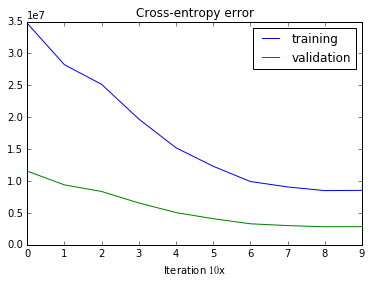

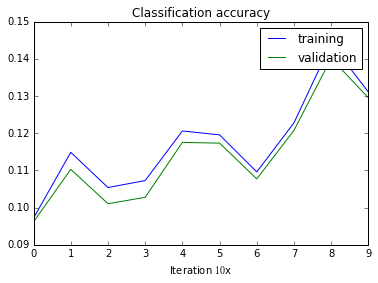

In [84]:
print("Time elapse: {0} minutes".format(elapsed / 60))
plot_error(training_error, validation_error, 'Cross-entropy error')
plot_error(training_accuracy, validation_accuracy, 'Classification accuracy')
print('Final Training accuracy', accuracy(y_train, nn.feed(X_train)))
print('Final Validation accuracy', accuracy(y_validation, nn.feed(X_validation)))